______________
Importing necessary libraries and setting global variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from models import UnbalancedBagger, UnbalancedBaggerNoSampling
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from statsmodels.stats.contingency_tables import mcnemar
import operator
from sklearn.metrics import precision_score

RANDOM_SEED = 12345

In [2]:
original_df = pd.read_csv("datasets/diabetes.csv")

In [3]:
original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
print("Amount of 0 values:")
print("Glucose: ", len(original_df[original_df["Glucose"] == 0]))
print("BloodPressure: ", len(original_df[original_df["BloodPressure"] == 0]))
print("SkinThickness: ", len(original_df[original_df["SkinThickness"] == 0]))
print("Insulin: ", len(original_df[original_df["Insulin"] == 0]))
print("BMI: ", len(original_df[original_df["BMI"] == 0]))

Amount of 0 values:
Glucose:  5
BloodPressure:  35
SkinThickness:  227
Insulin:  374
BMI:  11


In [5]:
def imputation(data, columns):
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data

In [6]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


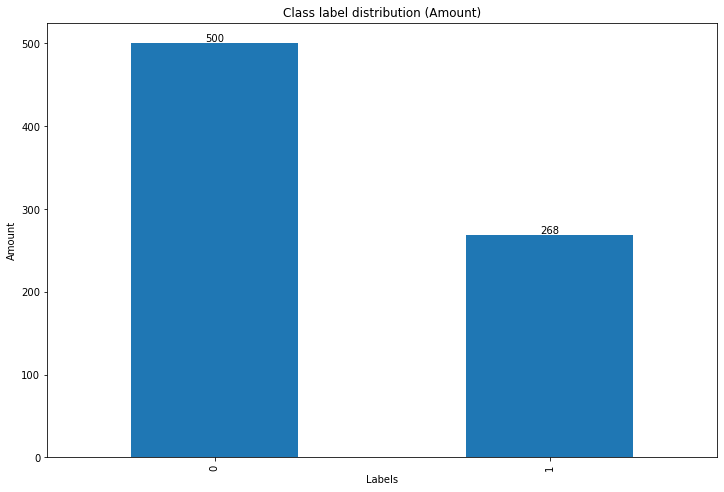

In [7]:
total_labels = original_df.Outcome.value_counts()
x_labels = [0,1]

plt.figure(figsize=(12,8))
ax = total_labels.plot(kind='bar')
ax.set_title('Class label distribution (Amount)')
ax.set_xlabel('Labels')
ax.set_ylabel('Amount')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect,lbl in zip(rects, total_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

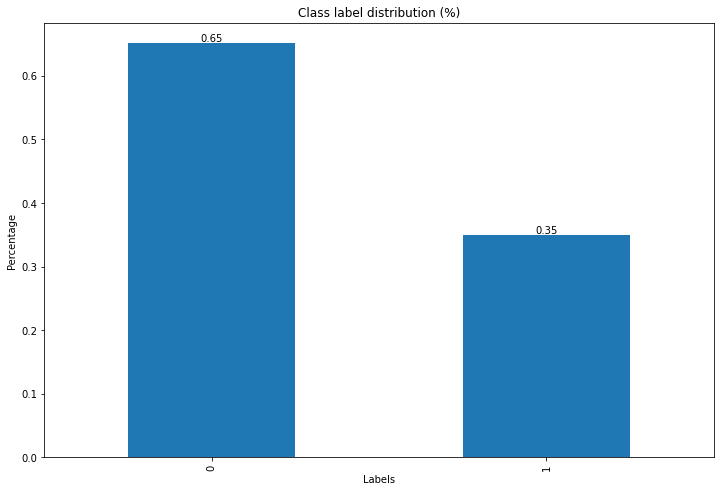

In [8]:
x_labels = [0,1]
total_labels_percentage = original_df.Outcome.value_counts()/len(original_df)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

In [9]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

#data_standardized used for SVC
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)
data_standardized = pd.DataFrame(data_standardized,columns=X.columns)

In [10]:
X_train,X_test,y_train,y_test, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

#standardized split for SVC
X_train_svc,X_test_svc,y_train_svc,y_test_svc, = train_test_split(data_standardized, y, test_size=0.3, random_state=RANDOM_SEED,stratify=y)

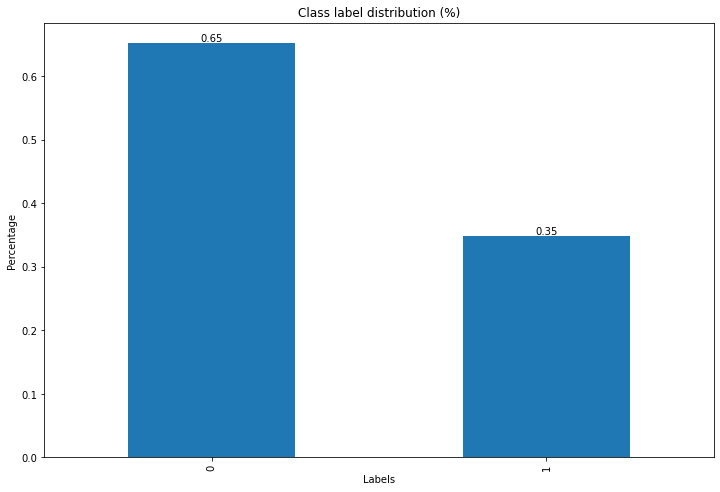

In [11]:
x_labels = [0,1]
total_labels_percentage = y_train.value_counts()/len(y_train)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

In [12]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
 ]

param_grid_dt = [
    {'splitter' : ['best', 'random'],
     'min_samples_split':[2,5,10],
     'min_samples_leaf':[1,5,10],
     'min_weight_fraction_leaf':[0,0.05, 0.1, 0.15, 0.2]
     }
]

dtc = DecisionTreeClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED, probability=True)

#Methods for sampling
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

search_dtc = GridSearchCV(dtc, param_grid_dt, cv=10, scoring='average_precision')
search_svc = GridSearchCV(svc, param_grid_svc, cv=10, scoring='average_precision')

list_of_auc = []
list_of_auprc = []
list_of_pos_probs = []
list_of_avg_prec = []
list_of_mcnemar_results = []
list_of_recall_results = []
list_of_precision_results = []

In [13]:
def smote_technique(X,y):
    x_sample, y_sample = smote.fit_sample(X, y)
    return x_sample,y_sample

def random_oversampling_technique(X,y):
    x_sample, y_sample = ros.fit_sample(X, y)
    return x_sample,y_sample

def random_undersampling_technique(X,y):
    x_sample, y_sample = rus.fit_sample(X, y)
    return x_sample,y_sample

In [14]:
def create_AUPRC_values(classifier, X_test, y_true):
    probs = classifier.predict_proba(X_test)
    pos_probs = probs[:,1]
    prec,recall,_ = precision_recall_curve(y_true, pos_probs)
    avg_prec = average_precision_score(y_true, probs)
    return prec,recall,avg_prec

In [15]:
def create_AUPRC_curves(list_of_rpl):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].set(xlabel="recall")
    axes[0].set(ylabel="precision")
    axes[1].set(xlabel="recall")
    axes[1].set(ylabel="precision")
    axes[0].set(title="DT")
    axes[1].set(title="SVC")
    for recall, prec, lbl in list_of_rpl:
        if "DT" in lbl:
            axes[0].plot(recall,prec,marker='.', label=lbl)
        else:
            axes[1].plot(recall,prec,marker='.', label=lbl)

    fig.tight_layout()

In [16]:
def get_AUC_plot_values(model, X, y, label):
    score = roc_auc_score(y,model.predict(X))
    return [label, score]

In [17]:
def get_AUPRC_values(model, X, y, label):
    probs = model.predict_proba(X)
    pos_probs = probs[:,1]
    prec,recall,_ = precision_recall_curve(y, pos_probs)
    avg_prec = average_precision_score(y, pos_probs)
    return [prec,recall,label], [avg_prec, label]

In [18]:
def create_AUPRC_bars(list_of_avg_prec):
    y, x = zip(*list_of_avg_prec)
    plt.figure(figsize=(12,8))
    plt.barh(x, y)
    plt.title("Average precision values for each model")
    for index, value in enumerate(y):
        plt.text(value, index, str("{0:.2f}".format(value)))

In [19]:
def create_AUC_bars_two(list_of_auc):
     x,y = zip(*list_of_auc)
     plt.figure(figsize=(12,8))
     plt.barh(x, y)
     plt.title("AUC values for each model")
     for index, value in enumerate(y):
         plt.text(value, index, str("{0:.2f}".format(value)))

In [20]:
def calculate_cont_table(model_one_preds, model_two_preds, true_preds):
    both_correct, model1_correct, model2_correct, non_correct = 0,0,0,0
    for idx in range(len(true_preds)):
        if model_one_preds[idx] == true_preds[idx]:
            if model_two_preds[idx] == true_preds[idx]:
                both_correct = both_correct + 1
            else:
                model1_correct = model1_correct + 1
        elif model_two_preds[idx] == true_preds[idx]:
            model2_correct = model2_correct + 1
        else:
            non_correct = non_correct + 1
    return [[both_correct,model1_correct],[model2_correct,non_correct]]

In [21]:
def calculate_mcneamar(table):
    result = mcnemar(table, exact=False, correction=True)
    return result.statistic, result.pvalue

In [22]:
def get_mcnemar_df():
    labels = []
    p_values = []
    stats = []
    for label, values in list_of_mcnemar_results:
        labels.append(label)
        stats.append(values[0])
        p_values.append(values[1])
    data = {'Model':labels, 'Statistic':stats, 'p_value':p_values}
    df = pd.DataFrame(data,columns=["Model", "Statistic", "p_value"])
    return df

In [23]:
#new method, using smote, ros, rus
sampling_techniques = [smote, ros, rus]
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)

dt_predict, dt_proba = UnbalancedBagger.unbalanced_bagger(X_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBagger.unbalanced_bagger(X_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

predictions_dt_unb = dt_predict(X_test)
predictions_svc_unb = svc_predict(X_test_svc)

recall = recall_score(y_test, predictions_dt_unb, average='binary',pos_label=1)
list_of_recall_results.append([recall, "Unb_bagging, DT"])
recall = recall_score(y_test_svc, predictions_svc_unb, average='binary',pos_label=1)
list_of_recall_results.append([recall, "Unb_bagging, SVC"])

precision = precision_score(y_test, predictions_dt_unb, average='binary',pos_label=1)
list_of_precision_results.append([precision, "Unb_bagging, DT"])
precision = precision_score(y_test_svc, predictions_svc_unb, average='binary',pos_label=1)
list_of_precision_results.append([precision, "Unb_bagging, SVC"])

score_dt = roc_auc_score(y_test,predictions_dt_unb)
score_svc = roc_auc_score(y_test_svc,predictions_svc_unb)

list_of_auc.append(['Unb_bagging, DT',score_dt])
list_of_auc.append(['Unb_bagging, SVC',score_svc])

probs_dt = dt_proba(X_test)
pos_probs = probs_dt[:,1]
prec,recall,_ = precision_recall_curve(y_test,pos_probs)
#
avg_prec = average_precision_score(y_test, pos_probs)
list_of_avg_prec.append([avg_prec, 'Unb_bagging, DT'])
#
list_of_auprc.append([prec,recall,'Unb_bagging, DT'])

probs_svc = svc_proba(X_test_svc)
pos_probs = probs_svc[:,1]
prec,recall,_ = precision_recall_curve(y_test_svc,pos_probs)
#
avg_prec = average_precision_score(y_test_svc, pos_probs)
list_of_avg_prec.append([avg_prec, 'Unb_bagging, SVC'])
#
list_of_auprc.append([prec,recall,'Unb_bagging, SVC'])

In [24]:
#Train on original data
dt_classifier = search_dtc.fit(X_train, y_train).best_estimator_
svc_classifier = search_svc.fit(X_train_svc, y_train_svc).best_estimator_

recall = recall_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Original, DT"])
recall = recall_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Original, SVC"])

precision = precision_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Original, DT"])
precision = precision_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Original, SVC"])

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Original,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Original,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Original,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Original,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["original_DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Original SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [25]:
#Train on SMOTE
sampled_dtc_x, sampled_dtc_y = smote_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = smote_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y).best_estimator_
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y).best_estimator_

recall = recall_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_recall_results.append([recall, "SMOTE, DT"])
recall = recall_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_recall_results.append([recall, "SMOTE, SVC"])

precision = precision_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_precision_results.append([precision, "SMOTE, DT"])
precision = precision_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_precision_results.append([precision, "SMOTE, SVC"])

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'SMOTE,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'SMOTE,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'SMOTE,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'SMOTE,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["SMOTE,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["SMOTE, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [26]:
#Train on random oversampling
sampled_dtc_x, sampled_dtc_y = random_oversampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_oversampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

recall = recall_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Rand_Over, DT"])
recall = recall_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Rand_Over, SVC"])

precision = precision_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Rand_Over, DT"])
precision = precision_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Rand_Over, SVC"])

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Rand_oversamp,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Rand_oversamp,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_oversamp,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_oversamp,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["Rand_Over,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Rand_Over, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345)
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [27]:
#Train on random undersampling
sampled_dtc_x, sampled_dtc_y = random_undersampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_undersampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

recall = recall_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Rand_Under, DT"])
recall = recall_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_recall_results.append([recall, "Rand_Under, SVC"])

precision = precision_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Rand_Under, DT"])
precision = precision_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Rand_Under, SVC"])

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Rand_undersamp,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Rand_undersamp,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_undersamp,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_undersamp,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["Rand_Under,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Rand_Under, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345)
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [28]:
#CHANGE, BAGGINBG NO SAMPLING TECHNIQUES
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,splitter='random',random_state=12345)

dt_predict, dt_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train, y_train, 10,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train_svc, y_train_svc, 10,random_seed=RANDOM_SEED)

predictions_dt = dt_predict(X_test)
predictions_svc = svc_predict(X_test_svc)

recall = recall_score(y_test, predictions_dt, average='binary',pos_label=1)
list_of_recall_results.append([recall, "Bagging, DT"])
recall = recall_score(y_test_svc, predictions_svc, average='binary',pos_label=1)
list_of_recall_results.append([recall, "Bagging, SVC"])

precision = precision_score(y_test, dt_classifier.predict(X_test), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Bagging, DT"])
precision = precision_score(y_test_svc, svc_classifier.predict(X_test_svc), average='binary',pos_label=1)
list_of_precision_results.append([precision, "Bagging, SVC"])

score_dt = roc_auc_score(y_test,predictions_dt)
score_svc = roc_auc_score(y_test_svc,predictions_svc)

list_of_auc.append(['Bagging, DT',score_dt])
list_of_auc.append(['Bagging, SVC',score_svc])

probs_dt = dt_proba(X_test)
pos_probs = probs_dt[:,1]
prec,recall,_ = precision_recall_curve(y_test,pos_probs)
#
avg_prec = average_precision_score(y_test, pos_probs)
list_of_avg_prec.append([avg_prec, 'Bagging, DT'])
#
list_of_auprc.append([prec,recall,'Bagging, DT'])

probs_svc = svc_proba(X_test_svc)
pos_probs = probs_svc[:,1]
prec,recall,_ = precision_recall_curve(y_test_svc,pos_probs)
#
avg_prec = average_precision_score(y_test_svc, pos_probs)
list_of_avg_prec.append([avg_prec, 'Bagging, SVC'])
#
list_of_auprc.append([prec,recall,'Bagging, SVC'])

table = calculate_cont_table(predictions_dt_unb, predictions_dt, y_test.values)
list_of_mcnemar_results.append(["bagging, DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, predictions_svc, y_test_svc.values)
list_of_mcnemar_results.append(["bagging, SVC", calculate_mcneamar(table)])

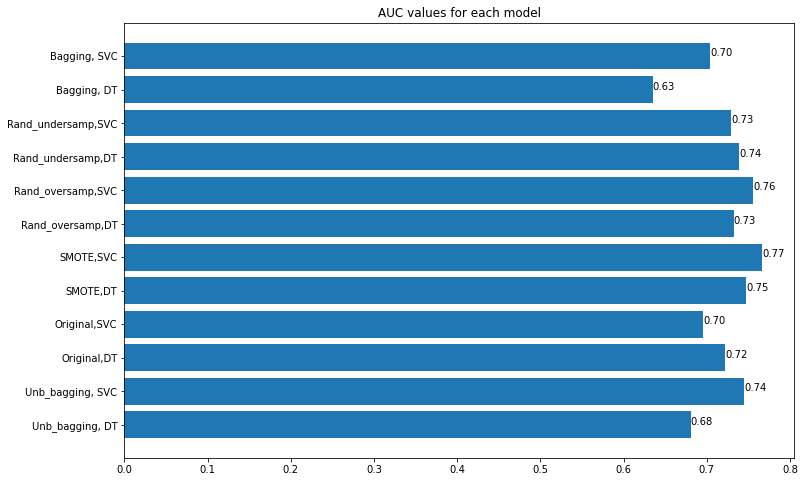

In [29]:
create_AUC_bars_two(list_of_auc)
plt.show()

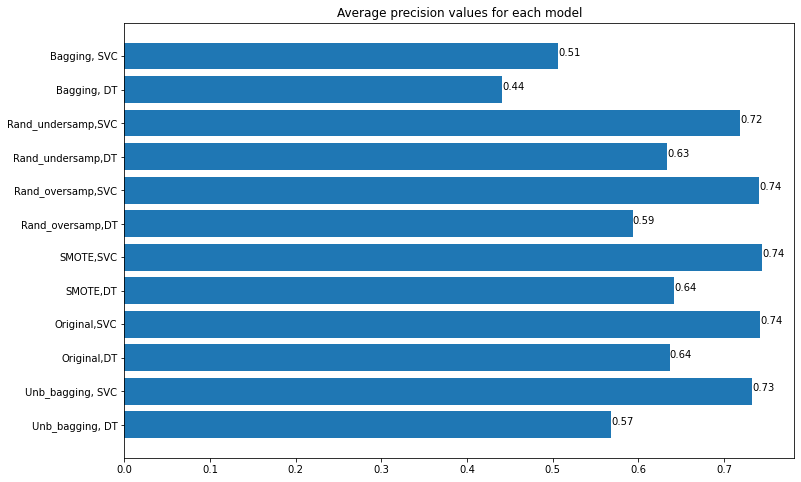

In [30]:
create_AUPRC_bars(list_of_avg_prec)
plt.show()

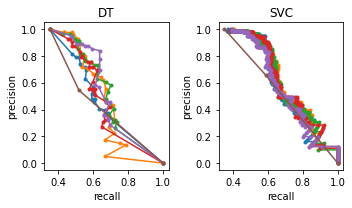

In [31]:
create_AUPRC_curves(list_of_auprc)
plt.show()

In [32]:
print(get_mcnemar_df())

             Model  Statistic   p_value
0      original_DT   0.927536  0.335504
1     Original SVC   0.033333  0.855132
2         SMOTE,DT   0.831169  0.361935
3       SMOTE, SVC   0.750000  0.386476
4     Rand_Over,DT   0.765957  0.381471
5   Rand_Over, SVC   0.071429  0.789268
6    Rand_Under,DT   0.876712  0.349104
7  Rand_Under, SVC   0.129032  0.719438
8      bagging, DT   1.592105  0.207026
9     bagging, SVC   1.020833  0.312321


In [33]:
print(list_of_recall_results)

[[0.5679012345679012, 'Unb_bagging, DT'], [0.7160493827160493, 'Unb_bagging, SVC'], [0.6172839506172839, 'Original, DT'], [0.5308641975308642, 'Original, SVC'], [0.7283950617283951, 'SMOTE, DT'], [0.7530864197530864, 'SMOTE, SVC'], [0.691358024691358, 'Rand_Over, DT'], [0.7654320987654321, 'Rand_Over, SVC'], [0.691358024691358, 'Rand_Under, DT'], [0.691358024691358, 'Rand_Under, SVC'], [0.5432098765432098, 'Bagging, DT'], [0.654320987654321, 'Bagging, SVC']]


In [34]:
def split(list):
    DT_list = []
    SVC_list = []
    for score,item in list:
        if 'DT' in item:
            DT_list.append([score,item])
        else:
            SVC_list.append([score,item])
    return DT_list, SVC_list

In [35]:
def sort(list):
    sorted_list = sorted(list, key=operator.itemgetter(0), reverse=True)
    return sorted_list

In [36]:
def create_bars(list, title):
     y,x = zip(*list)
     plt.figure(figsize=(12,8))
     plt.barh(x, y)
     plt.title(title)
     for index, value in enumerate(y):
         plt.text(value, index, str("{0:.2f}".format(value)))

In [49]:
dt_prec, svc_prec = split(list_of_precision_results)
sorted_dt = sort(dt_prec)
sorted_svc = sort(svc_prec)

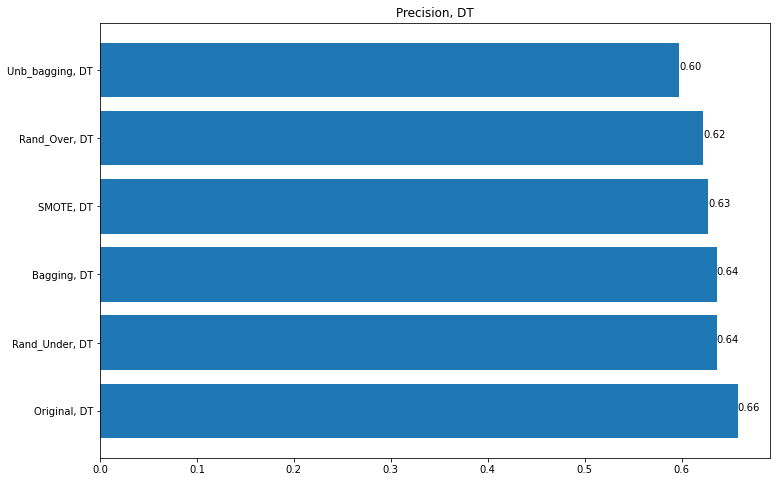

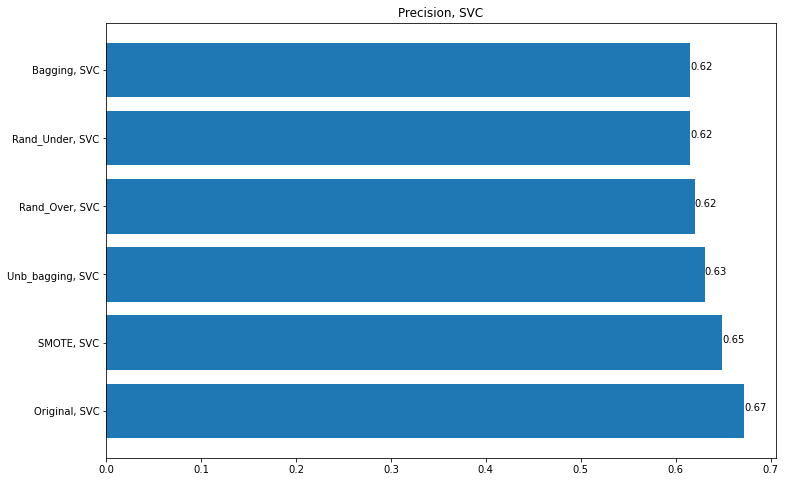

In [50]:
create_bars(sorted_dt, "Precision, DT")
create_bars(sorted_svc, "Precision, SVC")
plt.show()

In [51]:
dt_rec, svc_rec = split(list_of_recall_results)
sorted_dt = sort(dt_rec)
sorted_svc = sort(svc_rec)

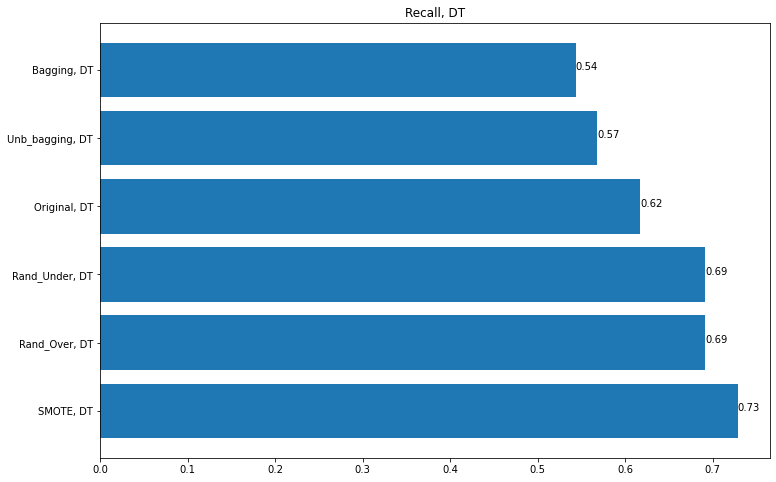

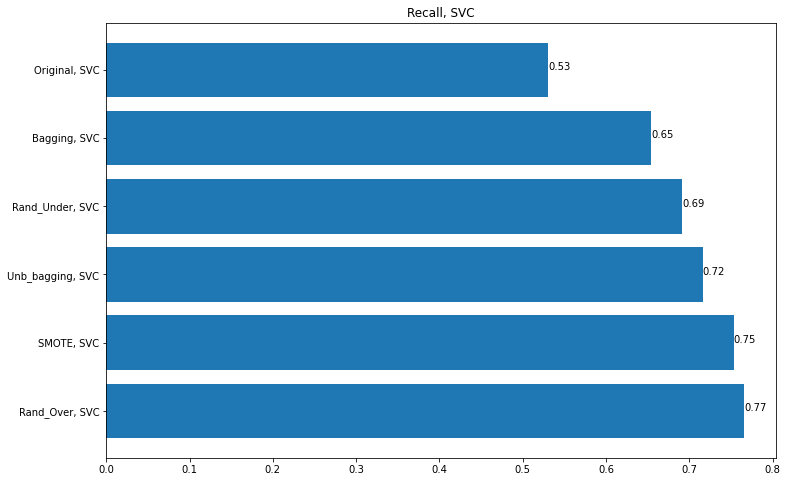

In [52]:
create_bars(sorted_dt, "Recall, DT")
create_bars(sorted_svc, "Recall, SVC")
plt.show()

